In [1]:
%load_ext autoreload
%autoreload 2

from cluster_g_logit_init_acceptpsi import *


%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering  # Add this import

def load_model_essentials(base_path='/Users/sarahurbut/Dropbox (Personal)/data_for_running/'):
    """
    Load all essential components
    """
    print("Loading components...")
    
    # Load large matrices
    Y = torch.load(base_path + 'Y_tensor.pt')
    E = torch.load(base_path + 'E_matrix.pt')
    G = torch.load(base_path + 'G_matrix.pt')
    
    # Load other components
    essentials = torch.load(base_path + 'model_essentials.pt')
    
    print("Loaded all components successfully!")
    
    return Y, E, G, essentials

# Load and initialize model:
Y, E, G, essentials = load_model_essentials()



Loading components...


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_31992/1069408875.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Y = torch.load(base_path + 'Y_tensor.pt')
/v

Loaded all components successfully!


In [8]:
# Count events per person
events_per_person = Y.sum(dim=(1,2))  # Sum over diseases and time
mask = events_per_person ==0

# Filter data
Y_filtered = Y[mask]
G_filtered = G[mask]
E_filtered = E[mask]

print(f"Original N: {Y.shape[0]}")
print(f"Filtered N: {Y_filtered.shape[0]}")
print(f"\nAverage events per person:")
print(f"Before filtering: {events_per_person.mean():.2f}")
print(f"After filtering: {events_per_person[mask].mean():.2f}")

Original N: 407878
Filtered N: 419

Average events per person:
Before filtering: 8.06
After filtering: 0.00


In [2]:

def subset_data(Y, E, G, n_samples=50000, seed=42):
    """
    Subset the data to n_samples individuals while maintaining consistency
    
    Args:
        Y: tensor of shape [N, D, T]
        E: tensor of shape [N, D]
        G: tensor of shape [N, P]
        n_samples: number of individuals to keep
        seed: random seed for reproducibility
    
    Returns:
        Y_sub, E_sub, G_sub: subsetted tensors
    """
    torch.manual_seed(seed)
    
    # Get total number of individuals
    N = Y.shape[0]
    
    # Randomly select n_samples indices
    indices = torch.randperm(N)[:n_samples]
    
    # Subset all matrices using the same indices
    Y_sub = Y[indices]
    E_sub = E[indices]
    G_sub = G[indices]
    
    print(f"Original shapes: Y={Y.shape}, E={E.shape}, G={G.shape}")
    print(f"New shapes: Y={Y_sub.shape}, E={E_sub.shape}, G={G_sub.shape}")
    
    return Y_sub, E_sub, G_sub, indices

# Subset the data
Y_100k, E_100k, G_100k, indices = subset_data(Y, E, G, n_samples=10000,seed=1)

torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# Initialize model with subsetted data


Original shapes: Y=torch.Size([407878, 348, 52]), E=torch.Size([407878, 348]), G=torch.Size([407878, 36])
New shapes: Y=torch.Size([10000, 348, 52]), E=torch.Size([10000, 348]), G=torch.Size([10000, 36])


In [3]:
# When initializing the model:
original_G = G_100k.clone().detach()  # Store the original G - proper tensor copy

# Now in your batch run, load and verify:
initial_psi = torch.load('initial_psi_400k.pt')
initial_clusters = torch.load('initial_clusters_400k.pt')

original_cluster_sizes = {}
unique, counts = np.unique(initial_clusters, return_counts=True)
for k, count in zip(unique, counts):
    original_cluster_sizes[k] = count
print("\nOriginal cluster sizes:")
for k, count in original_cluster_sizes.items():
    print(f"Cluster {k}: {count} diseases")


Original cluster sizes:
Cluster 0: 16 diseases
Cluster 1: 21 diseases
Cluster 2: 15 diseases
Cluster 3: 82 diseases
Cluster 4: 5 diseases
Cluster 5: 7 diseases
Cluster 6: 8 diseases
Cluster 7: 22 diseases
Cluster 8: 28 diseases
Cluster 9: 12 diseases
Cluster 10: 11 diseases
Cluster 11: 8 diseases
Cluster 12: 7 diseases
Cluster 13: 13 diseases
Cluster 14: 10 diseases
Cluster 15: 5 diseases
Cluster 16: 29 diseases
Cluster 17: 17 diseases
Cluster 18: 9 diseases
Cluster 19: 23 diseases


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_31992/685643090.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  initial_psi = torch.load('initial_psi_400k.pt'

In [17]:
print("Initial psi stats:")
print(f"Shape: {initial_psi.shape}")
print(f"Range: [{initial_psi.min():.2f}, {initial_psi.max():.2f}]")
print(f"Number of positive values: {(initial_psi > 0).sum().item()}")



Initial psi stats:
Shape: torch.Size([20, 348])
Range: [-2.04, 1.33]
Number of positive values: 348


In [18]:
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=Y_100k.shape[0],
    D=Y_100k.shape[1],
    T=Y_100k.shape[2],
    K=essentials['K'],
    P=essentials['P'],
    G=G_100k,
    Y=Y_100k,
    prevalence_t=essentials['prevalence_t']
)

# Initialize and train
model.initialize_params(true_psi=initial_psi)
model.clusters = initial_clusters
clusters_match = np.array_equal(initial_clusters, model.clusters)
print(f"\nClusters match exactly: {clusters_match}")  

/Users/sarahurbut/aladynoulli/pyScripts/cluster_g_logit_init_acceptpsi_flatlam.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G, dtype=torch.float32)
/Users/sarahurbut/aladynoulli/pyScripts/cluster_g_logit_init_acceptpsi_flatlam.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G_scaled, dtype=torch.float32)
/Users/sarahurbut/aladynoulli/pyScripts/cluster_g_logit_init_acceptpsi_flatlam.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)


Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00

Cluster Sizes:
Cluster 0: 11 diseases
Cluster 1: 6 diseases
Cluster 2: 13 diseases
Cluster 3: 97 diseases
Cluster 4: 22 diseases
Cluster 5: 22 diseases
Cluster 6: 15 diseases
Cluster 7: 17 diseases
Cluster 8: 35 diseases
Cluster 9: 6 diseases
Cluster 10: 13 diseases
Cluster 11: 9 diseases
Cluster 12: 11 diseases
Cluster 13: 6 diseases
Cluster 14: 17 diseases
Cluster 15: 5 diseases
Cluster 16: 15 diseases
Cluster 17: 8 diseases
Cluster 18: 17 diseases
Cluster 19: 3 diseases
Initialization complete!

Using true psi from simulation
Initialization complete!

Clusters match exactly: True


In [19]:
model.phi[1,1,:]

tensor([-13.3536, -13.3847, -13.3609, -13.2947, -13.1985, -13.0819, -12.9570,
        -12.8368, -12.7224, -12.6231, -12.5360, -12.4614, -12.3976, -12.3397,
        -12.2819, -12.2289, -12.1717, -12.1157, -12.0542, -11.9904, -11.9242,
        -11.8547, -11.7801, -11.7081, -11.6286, -11.5523, -11.4756, -11.3966,
        -11.3185, -11.2424, -11.1665, -11.0922, -11.0137, -10.9377, -10.8639,
        -10.7871, -10.7146, -10.6440, -10.5761, -10.5175, -10.4630, -10.4224,
        -10.3956, -10.3801, -10.3754, -10.3802, -10.3969, -10.4189, -10.4377,
        -10.4556, -10.4664, -10.4657], grad_fn=<SliceBackward0>)

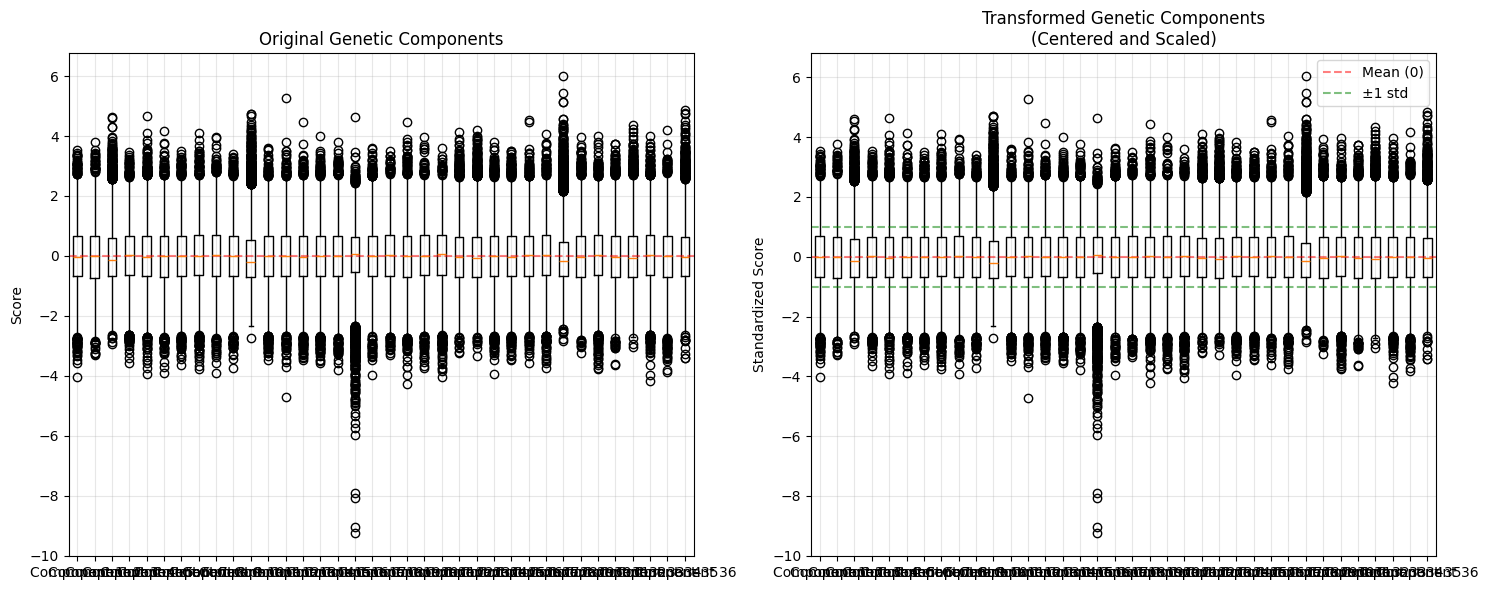


Genetic Components Summary Statistics:
Component  Original Mean Original Std  Trans. Mean  Trans. Std
------------------------------------------------------------
1                 -0.007        1.004       -0.000       1.000
2                 -0.001        1.011       -0.000       1.000
3                  0.018        1.005       -0.000       1.000
4                  0.009        0.977       -0.000       1.000
5                  0.000        1.005        0.000       1.000
6                 -0.013        1.007        0.000       1.000
7                  0.012        1.001       -0.000       1.000
8                  0.012        1.001       -0.000       1.000
9                  0.017        1.006        0.000       1.000
10                 0.010        1.001        0.000       1.000
11                 0.013        1.002       -0.000       1.000
12                 0.005        0.998        0.000       1.000
13                -0.001        0.998        0.000       1.000
14               

In [20]:

# Plot both versions:
model.plot_genetic_scores(original_G)
print(model.G[:,3].mean())

print(original_G[:,3].mean())


# Check G matrix scaling
G_mean = model.G.mean(dim=0)
G_std = model.G.std(dim=0)
print("\nG matrix scaling check:")
print(f"Mean should be ~0: {G_mean.abs().max().item():.6f}")
print(f"Std should be ~1: {(G_std - 1).abs().max().item():.6f}")


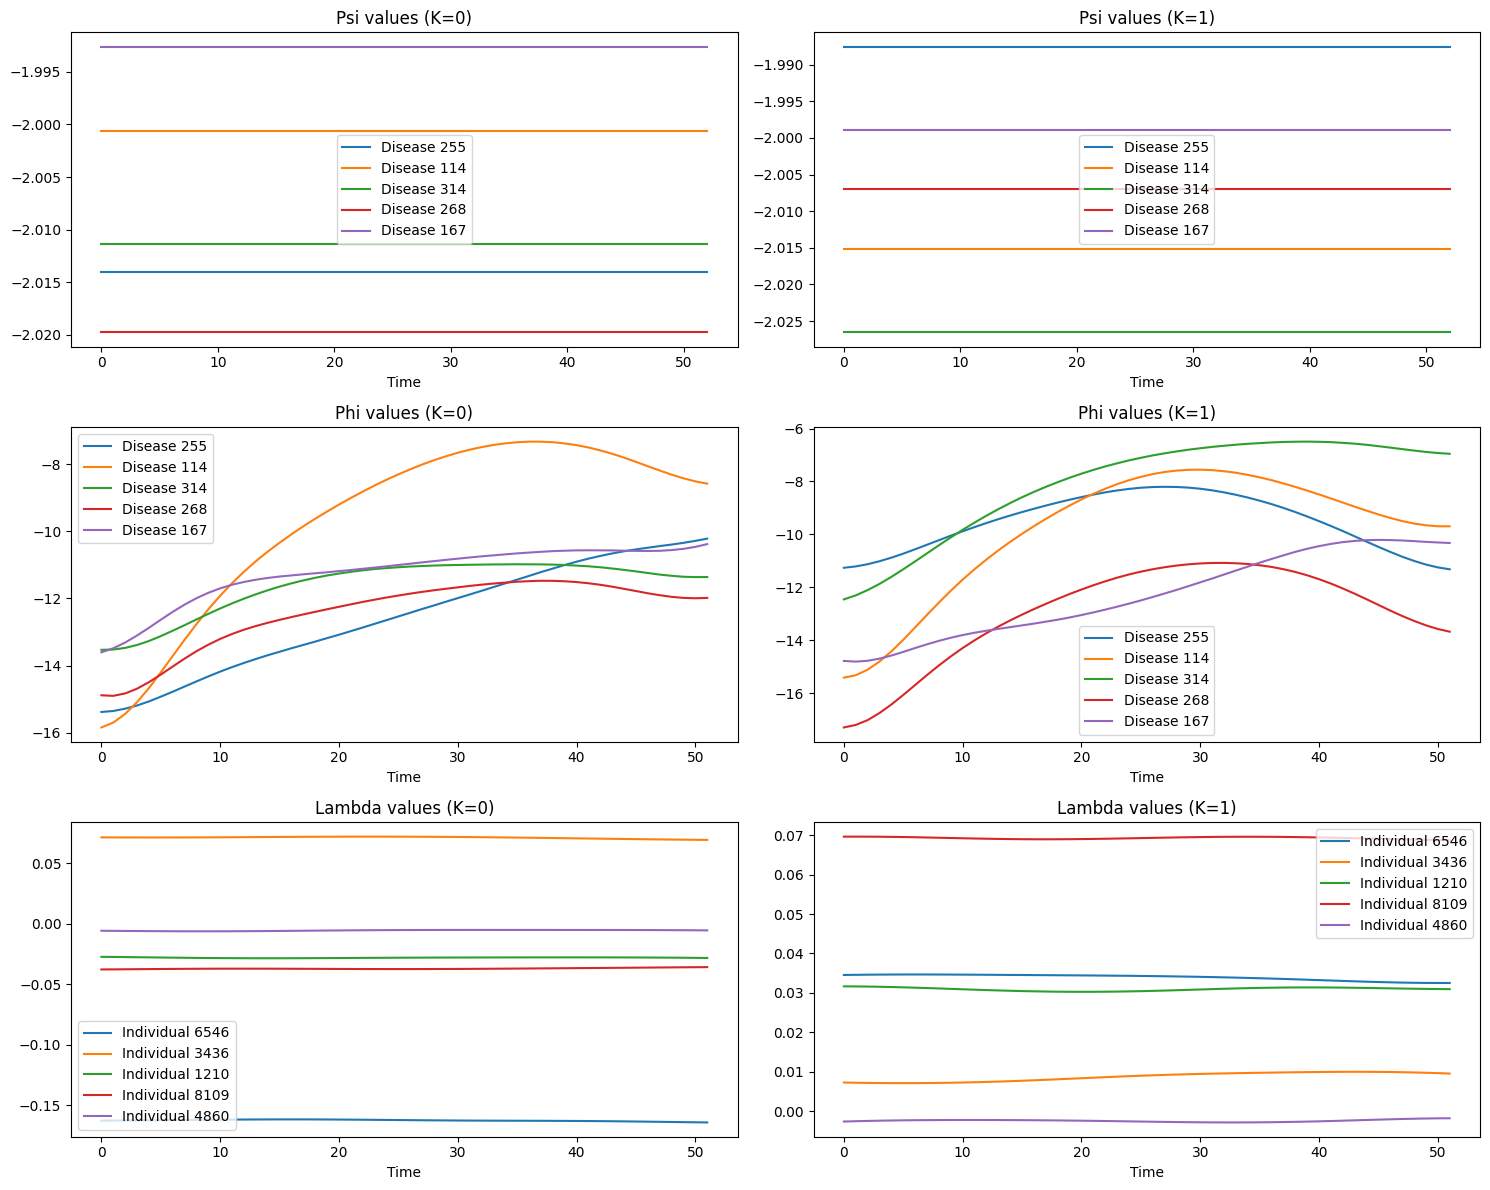


Cluster membership for sampled diseases:
Disease 255: Cluster 3
Disease 114: Cluster 5
Disease 314: Cluster 7
Disease 268: Cluster 8
Disease 167: Cluster 14


In [21]:
model.plot_initial_params()

In [22]:
initial_gamma = model.gamma.detach().clone()
initial_phi = model.phi.detach().clone()
initial_lambda = model.lambda_.detach().clone()
initial_psi = model.psi.detach().clone()


In [23]:

history_new = model.fit(E_100k, num_epochs=300, learning_rate=1e-4, lambda_reg=1e-2)
        

Starting training...


/Users/sarahurbut/aladynoulli/pyScripts/cluster_g_logit_init_acceptpsi_flatlam.py:209: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)


mask_before_event shape: torch.Size([10000, 348, 52])
mask_at_event shape: torch.Size([10000, 348, 52])

Epoch 0
Loss: 586.4868
Psi gradient stats:
Mean: 6.3960e-05
Std:  4.7301e-03
Max:  1.6373e-02
Min:  -2.1012e-02
Epoch 0, Loss: 586.4868, Gradients - Lambda: 5.663e-04, Phi: 1.418e+01, Gamma: 5.044e-05, Psi: 2.101e-02
mask_before_event shape: torch.Size([10000, 348, 52])
mask_at_event shape: torch.Size([10000, 348, 52])

Epoch 1
Loss: 518.0997
Psi gradient stats:
Mean: 6.4122e-05
Std:  4.7237e-03
Max:  1.6343e-02
Min:  -2.0992e-02
Epoch 1, Loss: 518.0997, Gradients - Lambda: 4.306e-02, Phi: 1.358e+01, Gamma: 1.107e-03, Psi: 2.099e-02

Estimated total training time: 154.5 minutes
mask_before_event shape: torch.Size([10000, 348, 52])
mask_at_event shape: torch.Size([10000, 348, 52])

Epoch 2
Loss: 449.3719
Psi gradient stats:
Mean: 6.4480e-05
Std:  4.7172e-03
Max:  1.6314e-02
Min:  -2.0968e-02
Epoch 2, Loss: 449.3719, Gradients - Lambda: 2.546e-02, Phi: 1.297e+01, Gamma: 1.236e-03, Psi

KeyboardInterrupt: 

In [24]:
final_lambda = model.lambda_.detach().clone()
diff = torch.abs(final_lambda - initial_lambda)

print(f"Lambda changes with lr=1e-4:")
print(f"Mean absolute change: {torch.mean(diff):.3e}")
print(f"Max absolute change: {torch.max(diff):.3e}")
print(f"Std of changes: {torch.std(diff):.3e}")

Lambda changes with lr=1e-4:
Mean absolute change: 5.946e-06
Max absolute change: 1.347e-03
Std of changes: 9.606e-06


NameError: name 'history_new' is not defined

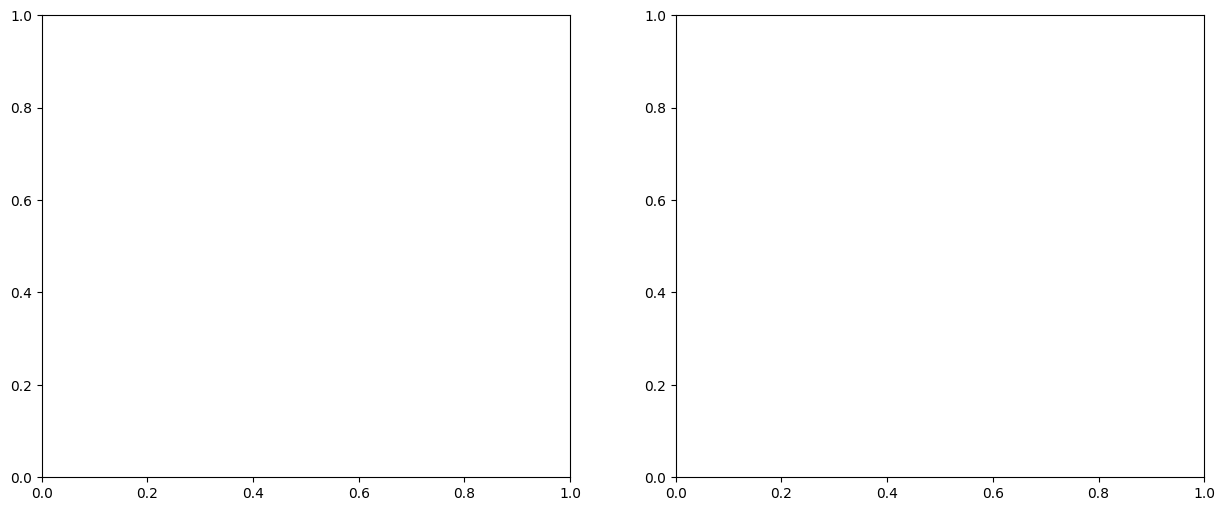

In [25]:

import matplotlib.pyplot as plt

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot loss
ax1.plot(history_new['loss'])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.grid(True)

# Plot gradients
ax2.plot(history_new['max_grad_lambda'], label='Lambda')
ax2.plot(history_new['max_grad_phi'], label='Phi')
ax2.plot(history_new['max_grad_psi'], label='Psi')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Max Gradient Magnitude')
ax2.set_title('Parameter Gradients')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [14]:
# First get the trained parameters from your existing model
pretrained_phi = model.phi.detach().clone()
pretrained_gamma = model.gamma.detach().clone()
pretrained_psi = model.psi.detach().clone()

# Get a new batch of 10k individuals
Y_new, E_new, G_new, new_indices = subset_data(Y, E, G, n_samples=10000, seed=43)  # Using different seed


Original shapes: Y=torch.Size([407878, 348, 52]), E=torch.Size([407878, 348]), G=torch.Size([407878, 36])
New shapes: Y=torch.Size([10000, 348, 52]), E=torch.Size([10000, 348]), G=torch.Size([10000, 36])


In [17]:
from gp_clust_pretrained import *
%load_ext autoreload
%autoreload 2


# Create pretrained model for new data
pretrained_model = AladynSurvivalPretrainedModel(
    N=Y_new.shape[0],  # 10000
    D=Y_new.shape[1],  # same number of diseases
    T=Y_new.shape[2],  # same time points
    K=essentials['K'],  # same number of clusters
    P=essentials['P'],  # same number of genetic components
    G=G_new,           # genetic data for new individuals
    Y=Y_new,           # outcome data for new individuals
    prevalence_t=essentials['prevalence_t'],  # same prevalence
    pretrained_phi=pretrained_phi,
    pretrained_gamma=pretrained_gamma,
    pretrained_psi=pretrained_psi
)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00


/Users/sarahurbut/aladynoulli/pyScripts/gp_clust_pretrained.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G, dtype=torch.float32)
/Users/sarahurbut/aladynoulli/pyScripts/gp_clust_pretrained.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G_scaled, dtype=torch.float32)
/Users/sarahurbut/aladynoulli/pyScripts/gp_clust_pretrained.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)
/Users/sarahurbut/aladynoulli/pyScripts/gp_clust_pretrained.

Pretrained model stats:
G stats: mean=0.000, std=1.000
gamma stats: mean=0.003, std=0.020
Initial lambda stats: mean=-0.003, std=1.010
phi stats: mean=-11.049, std=2.518
Initialization complete! Only lambda parameters will be updated.


In [18]:

# Fit only lambda parameters for new individuals
history_new = pretrained_model.fit(E_new, num_epochs=100, learning_rate=1e-3)



Starting training (lambda parameters only)...


/Users/sarahurbut/aladynoulli/pyScripts/gp_clust_pretrained.py:178: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)


mask_before_event shape: torch.Size([10000, 348, 52])
mask_at_event shape: torch.Size([10000, 348, 52])
Epoch 0, Loss: 587.1111, Lambda gradient: 5.442e-01
mask_before_event shape: torch.Size([10000, 348, 52])
mask_at_event shape: torch.Size([10000, 348, 52])
Epoch 1, Loss: 384.6211, Lambda gradient: 4.008e-01
mask_before_event shape: torch.Size([10000, 348, 52])
mask_at_event shape: torch.Size([10000, 348, 52])
Epoch 2, Loss: 308.7187, Lambda gradient: 2.863e-01
mask_before_event shape: torch.Size([10000, 348, 52])
mask_at_event shape: torch.Size([10000, 348, 52])
Epoch 3, Loss: 311.3310, Lambda gradient: 2.849e-01
mask_before_event shape: torch.Size([10000, 348, 52])
mask_at_event shape: torch.Size([10000, 348, 52])
Epoch 4, Loss: 318.6316, Lambda gradient: 2.646e-01
mask_before_event shape: torch.Size([10000, 348, 52])
mask_at_event shape: torch.Size([10000, 348, 52])
Epoch 5, Loss: 296.9107, Lambda gradient: 2.494e-01
mask_before_event shape: torch.Size([10000, 348, 52])
mask_at_ev

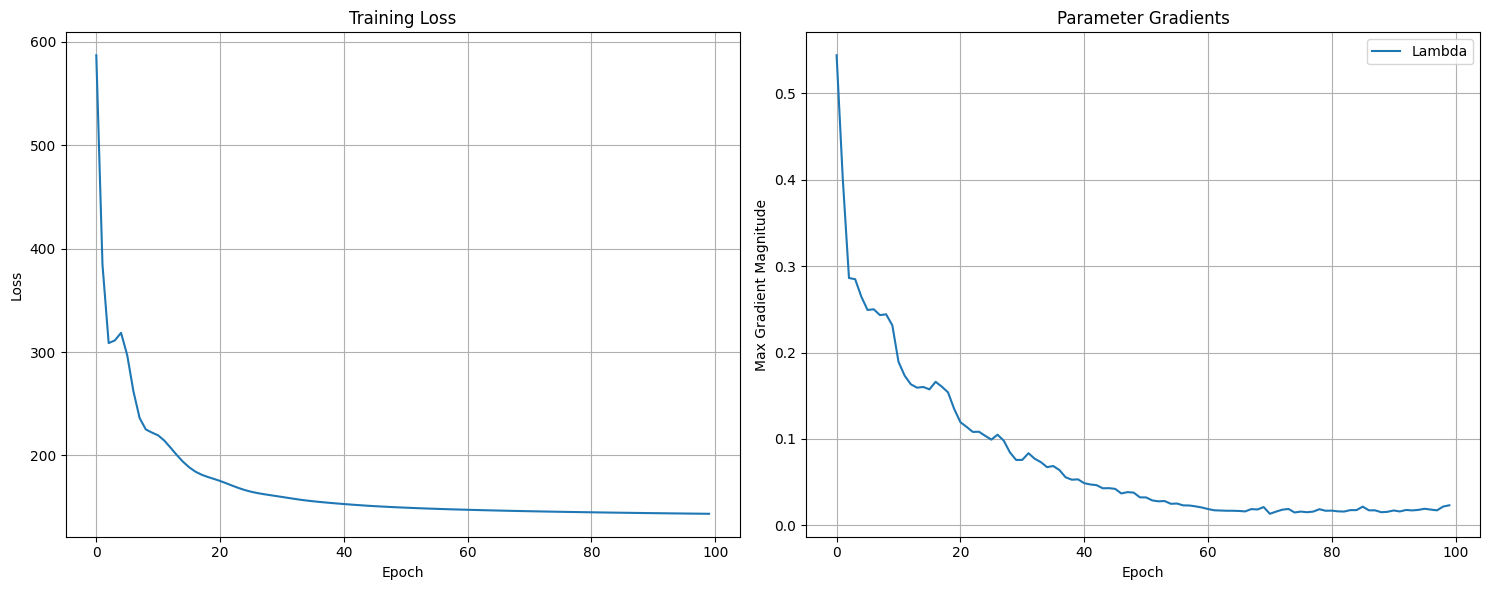

In [19]:

import matplotlib.pyplot as plt

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot loss
ax1.plot(history_new['loss'])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.grid(True)

# Plot gradients
ax2.plot(history_new['max_grad_lambda'], label='Lambda')

ax2.set_xlabel('Epoch')
ax2.set_ylabel('Max Gradient Magnitude')
ax2.set_title('Parameter Gradients')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [20]:
disease_names=essentials['disease_names']

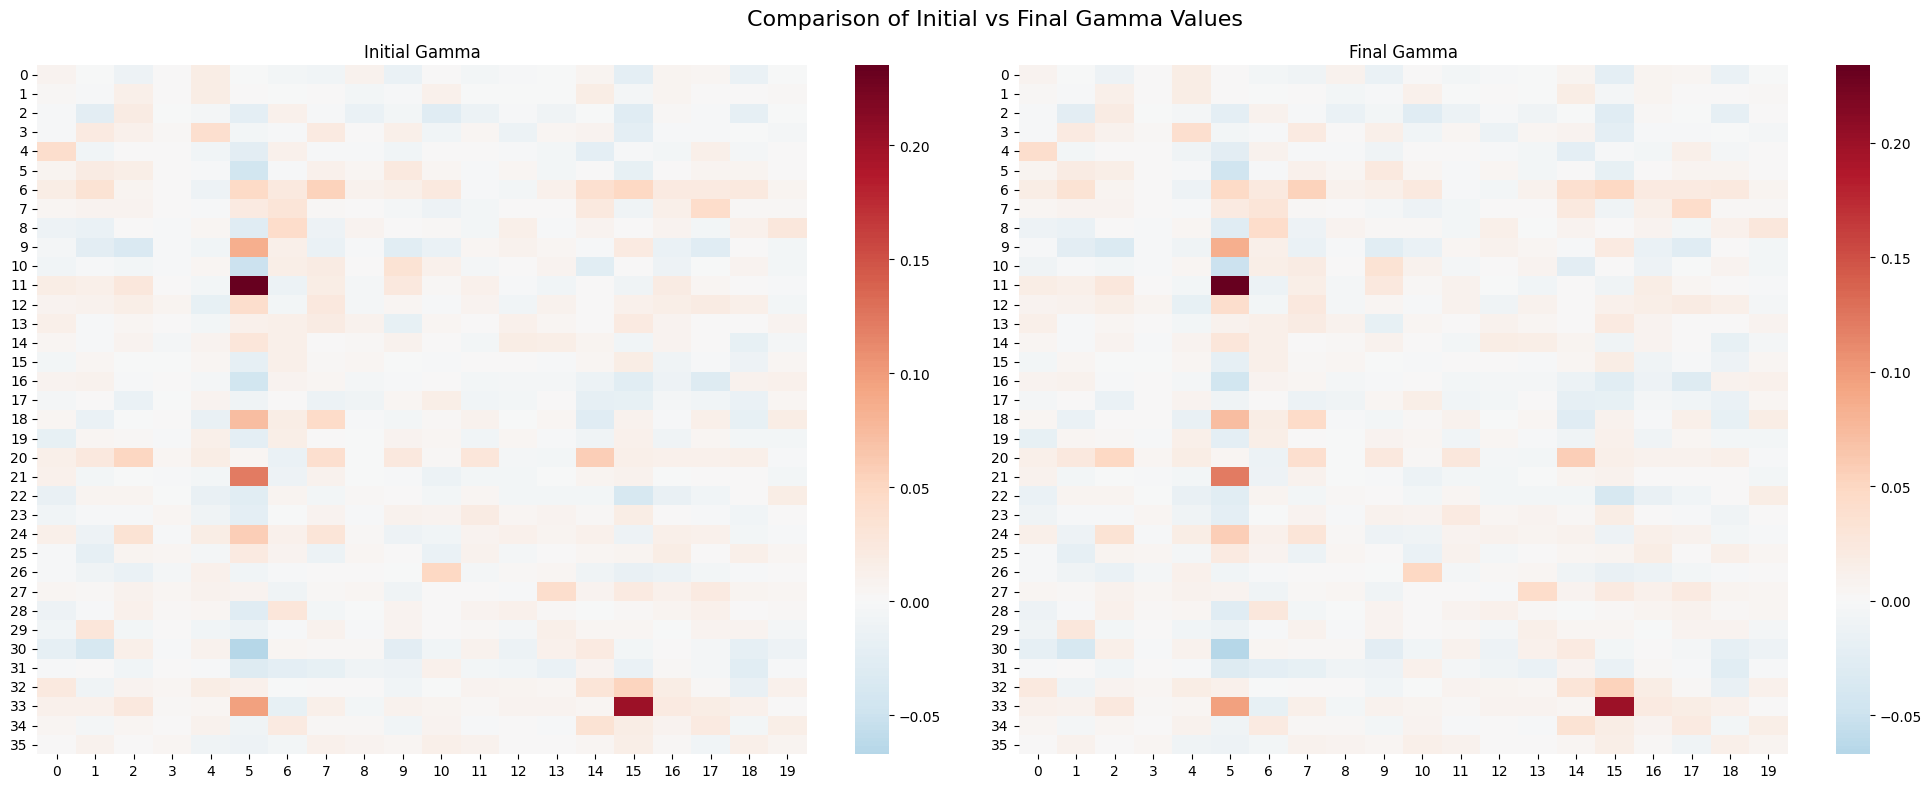

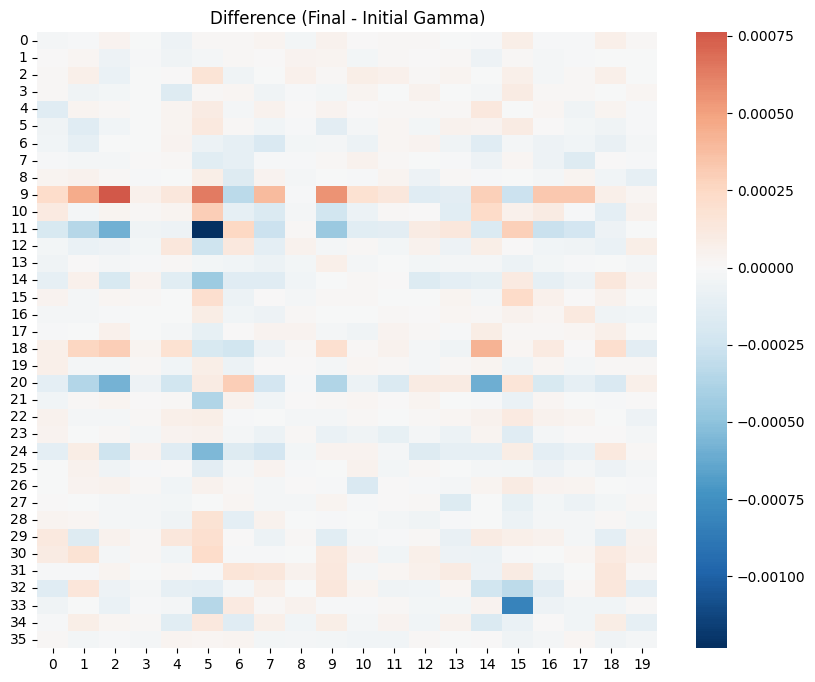

Mean absolute difference: 0.0001
Max absolute difference: 0.0012
Standard deviation of differences: 0.0001


In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert gamma tensors to numpy arrays
initial_gamma_np = initial_gamma.detach().numpy()
final_gamma_np = model.gamma.detach().numpy()

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot initial gamma
sns.heatmap(initial_gamma_np, ax=ax1, cmap='RdBu_r', center=0)
ax1.set_title('Initial Gamma')

# Plot final gamma
sns.heatmap(final_gamma_np, ax=ax2, cmap='RdBu_r', center=0)
ax2.set_title('Final Gamma')

# Add a title to the figure
plt.suptitle('Comparison of Initial vs Final Gamma Values', fontsize=16)

# You can also add a colorbar
plt.tight_layout()

# To see the actual difference, you can also create a difference heatmap
plt.figure(figsize=(10, 8))
diff = final_gamma_np - initial_gamma_np
sns.heatmap(diff, cmap='RdBu_r', center=0)
plt.title('Difference (Final - Initial Gamma)')
plt.show()

# Print some summary statistics
print(f"Mean absolute difference: {np.abs(diff).mean():.4f}")
print(f"Max absolute difference: {np.abs(diff).max():.4f}")
print(f"Standard deviation of differences: {np.std(diff):.4f}")

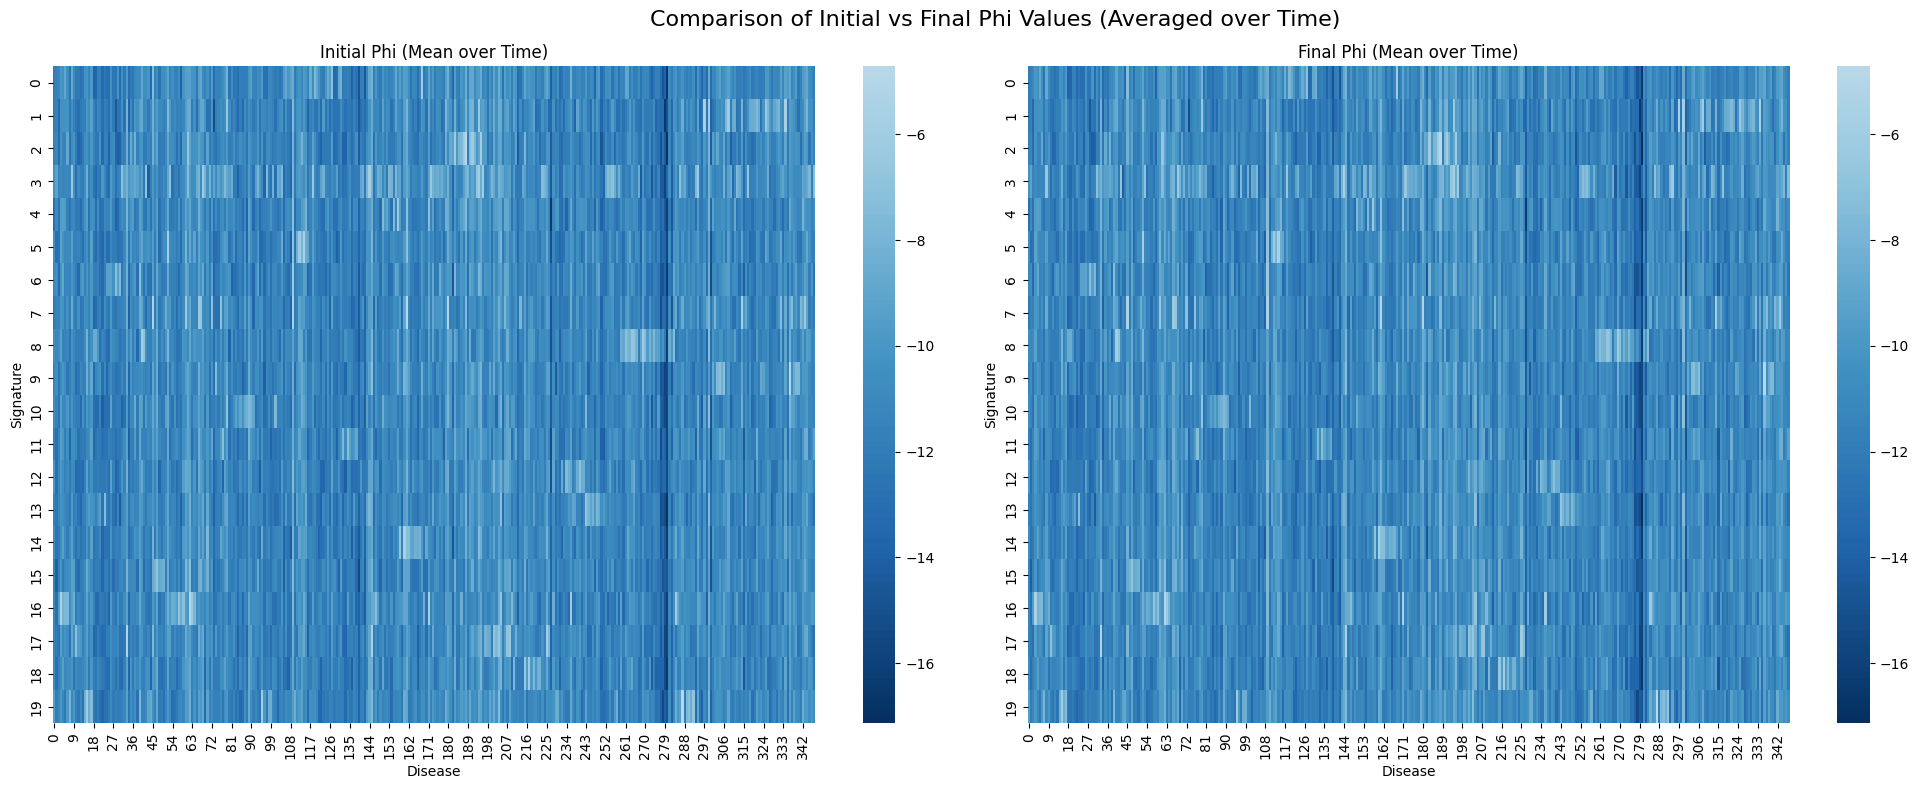

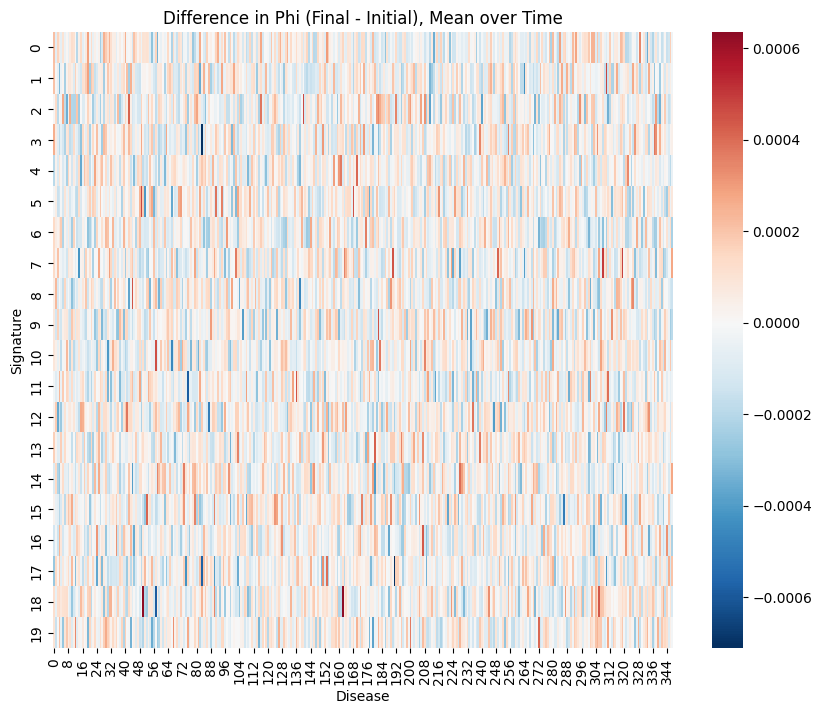

Full tensor statistics:
Mean absolute difference: 0.0010
Max absolute difference: 0.0093
Standard deviation of differences: 0.0012

Time-averaged statistics:
Mean absolute difference: 0.0001
Max absolute difference: 0.0007
Standard deviation of differences: 0.0001


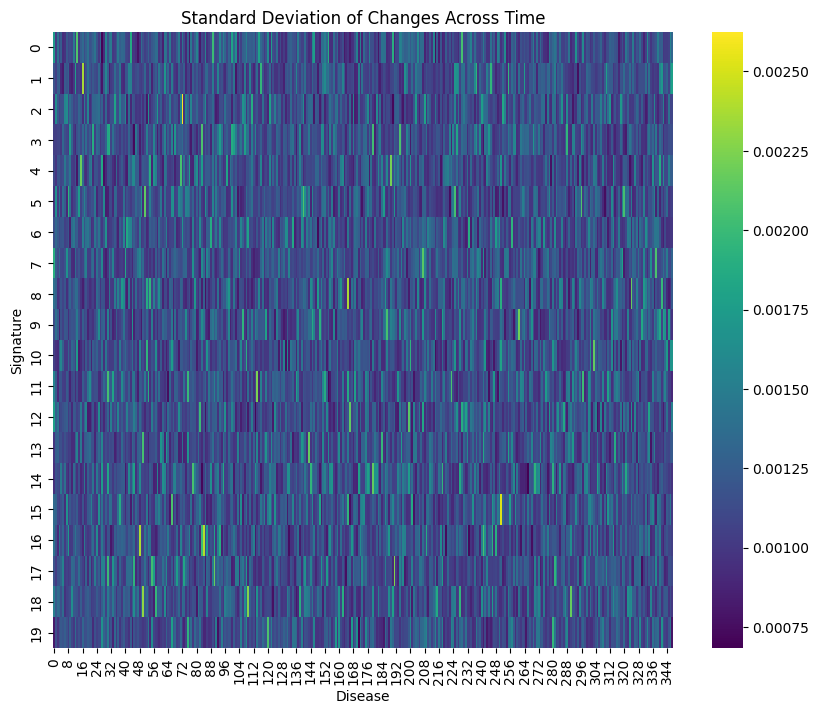

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert phi tensors to numpy arrays
initial_phi_np = initial_phi.detach().numpy()  # Shape: (K, D, T)
final_phi_np = model.phi.detach().numpy()

# Take mean over time dimension
initial_phi_mean = initial_phi_np.mean(axis=2)  # Shape: (K, D)
final_phi_mean = final_phi_np.mean(axis=2)

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot initial phi (averaged over time)
sns.heatmap(initial_phi_mean, ax=ax1, cmap='RdBu_r', center=0)
ax1.set_title('Initial Phi (Mean over Time)')
ax1.set_xlabel('Disease')
ax1.set_ylabel('Signature')

# Plot final phi (averaged over time)
sns.heatmap(final_phi_mean, ax=ax2, cmap='RdBu_r', center=0)
ax2.set_title('Final Phi (Mean over Time)')
ax2.set_xlabel('Disease')
ax2.set_ylabel('Signature')

plt.suptitle('Comparison of Initial vs Final Phi Values (Averaged over Time)', fontsize=16)
plt.tight_layout()

# Plot difference
plt.figure(figsize=(10, 8))
diff_mean = final_phi_mean - initial_phi_mean
sns.heatmap(diff_mean, cmap='RdBu_r', center=0)
plt.title('Difference in Phi (Final - Initial), Mean over Time')
plt.xlabel('Disease')
plt.ylabel('Signature')
plt.show()

# Print summary statistics for both full tensor and time-averaged differences
print("Full tensor statistics:")
diff_full = final_phi_np - initial_phi_np
print(f"Mean absolute difference: {np.abs(diff_full).mean():.4f}")
print(f"Max absolute difference: {np.abs(diff_full).max():.4f}")
print(f"Standard deviation of differences: {np.std(diff_full):.4f}")

print("\nTime-averaged statistics:")
print(f"Mean absolute difference: {np.abs(diff_mean).mean():.4f}")
print(f"Max absolute difference: {np.abs(diff_mean).max():.4f}")
print(f"Standard deviation of differences: {np.std(diff_mean):.4f}")

# Optionally, look at temporal variation
temporal_std = np.std(diff_full, axis=2)
plt.figure(figsize=(10, 8))
sns.heatmap(temporal_std, cmap='viridis')
plt.title('Standard Deviation of Changes Across Time')
plt.xlabel('Disease')
plt.ylabel('Signature')
plt.show()

In [29]:
Y_global=Y


In [30]:
Y_global.shape

torch.Size([407878, 348, 52])

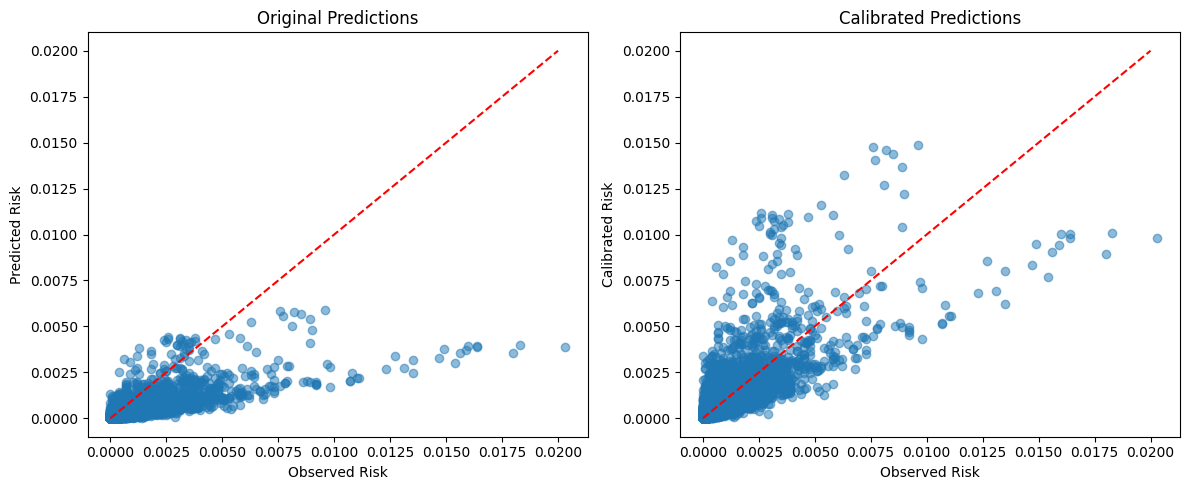

Mean observed risk: 0.000439
Mean predicted risk (original): 0.000173
Mean predicted risk (calibrated): 0.000439
Calibration scale factor: 2.532


In [31]:
# 1. Get predictions and actual values
predicted = model.forward()
pi_pred = predicted[0] if isinstance(predicted, tuple) else predicted
pi_pred = pi_pred.cpu().detach().numpy()
Y = model.Y.cpu().detach().numpy()

# 2. Calculate marginal risks directly
# Assuming dimensions are: [N, D, T] for both Y and pi_pred
observed_risk = Y.mean(axis=0).flatten()  # average across individuals
predicted_risk = pi_pred.mean(axis=0).flatten()

# 3. Apply calibration
scale_factor = np.mean(observed_risk) / np.mean(predicted_risk)
calibrated_risk = predicted_risk * scale_factor

# 4. Plot
plt.figure(figsize=(12, 5))

# Original predictions
plt.subplot(121)
plt.scatter(observed_risk, predicted_risk, alpha=0.5)
plt.plot([0, 0.02], [0, 0.02], 'r--')  # y=x line
plt.title('Original Predictions')
plt.xlabel('Observed Risk')
plt.ylabel('Predicted Risk')

# Calibrated predictions
plt.subplot(122)
plt.scatter(observed_risk, calibrated_risk, alpha=0.5)
plt.plot([0, 0.02], [0, 0.02], 'r--')  # y=x line
plt.title('Calibrated Predictions')
plt.xlabel('Observed Risk')
plt.ylabel('Calibrated Risk')

plt.tight_layout()
plt.show()

# Print statistics
print(f"Mean observed risk: {np.mean(observed_risk):.6f}")
print(f"Mean predicted risk (original): {np.mean(predicted_risk):.6f}")
print(f"Mean predicted risk (calibrated): {np.mean(calibrated_risk):.6f}")
print(f"Calibration scale factor: {scale_factor:.3f}")


In [33]:

ss_res = np.sum((observed_risk - calibrated_risk) ** 2)
ss_tot = np.sum((observed_risk - np.mean(observed_risk)) ** 2)
r2 = 1 - (ss_res / ss_tot)

print(f"R^2: {r2:.3f}")

R^2: 0.551


In [28]:
def plot_signature_top_diseases_centered(model, disease_names, n_top=10):
    """
    Show top diseases for each signature, centered relative to prevalence
    """
    # Get phi and prevalence
    phi = model.phi.detach().numpy()  # Shape: (K, D, T)
    prevalence_logit = model.logit_prev_t.detach().numpy()  # Shape: (D, T)
    
    # Center phi relative to prevalence
    phi_centered = np.zeros_like(phi)
    for k in range(phi.shape[0]):
        for d in range(phi.shape[1]):
            phi_centered[k, d, :] = phi[k, d, :] - prevalence_logit[d, :]
    
    # Average over time
    phi_avg = phi_centered.mean(axis=2)  # Shape: (K, D)
    
    # For each signature, get top diseases
    for k in range(phi_avg.shape[0]):
        scores = phi_avg[k, :]
        top_indices = np.argsort(scores)[-n_top:][::-1]
        
        print(f"\nTop {n_top} diseases in Signature {k} (relative to baseline):")
        for idx in top_indices:
            avg_effect = scores[idx]
            temporal_std = np.std(phi_centered[k, idx, :])
            # Convert to odds ratio for interpretability
            odds_ratio = np.exp(avg_effect)
            print(f"{disease_names[idx]}: effect={avg_effect:.3f} (OR={odds_ratio:.2f}), std={temporal_std:.3f}")

# Run visualization
plot_signature_top_diseases_centered(model, essentials['disease_names'])


Top 10 diseases in Signature 0 (relative to baseline):
Pleurisy; pleural effusion: effect=2.155 (OR=8.62), std=0.656
Cardiomegaly: effect=1.461 (OR=4.31), std=1.104
Other forms of chronic heart disease: effect=1.372 (OR=3.94), std=0.455
Atrial fibrillation and flutter: effect=1.338 (OR=3.81), std=0.804
Disease of tricuspid valve: effect=1.223 (OR=3.40), std=1.015
Rheumatic disease of the heart valves: effect=1.172 (OR=3.23), std=0.443
Congestive heart failure (CHF) NOS: effect=1.127 (OR=3.09), std=0.596
Pericarditis: effect=0.806 (OR=2.24), std=0.558
Paroxysmal ventricular tachycardia: effect=0.801 (OR=2.23), std=0.258
Heart failure NOS: effect=0.610 (OR=1.84), std=0.774

Top 10 diseases in Signature 1 (relative to baseline):
Rheumatoid arthritis: effect=2.618 (OR=13.71), std=0.576
Osteoarthritis; localized: effect=1.849 (OR=6.36), std=0.472
Pain in joint: effect=1.846 (OR=6.33), std=0.241
Hallux rigidus: effect=1.822 (OR=6.18), std=0.467
Hammer toe (acquired): effect=1.582 (OR=4.87),

In [29]:
def compare_disease_rankings(model, disease_names, n_top=10):
    """
    Compare initial vs final disease rankings for each signature
    """
    # Get initial rankings from psi
    psi = model.psi.detach().numpy()  # Shape: (K, D)
    
    # Get final rankings from centered phi
    phi = model.phi.detach().numpy()  # Shape: (K, D, T)
    prevalence_logit = model.logit_prev_t.detach().numpy()  # Shape: (D, T)
    
    # Center phi relative to prevalence
    phi_centered = np.zeros_like(phi)
    for k in range(phi.shape[0]):
        for d in range(phi.shape[1]):
            phi_centered[k, d, :] = phi[k, d, :] - prevalence_logit[d, :]
    
    # Average over time
    phi_avg = phi_centered.mean(axis=2)  # Shape: (K, D)
    
    # Compare rankings for each signature
    for k in range(phi_avg.shape[0]):
        print(f"\nSignature {k}:")
        
        # Get initial top diseases from psi
        initial_scores = psi[k, :]
        initial_top = np.argsort(initial_scores)[-n_top:][::-1]
        
        # Get final top diseases from phi
        final_scores = phi_avg[k, :]
        final_top = np.argsort(final_scores)[-n_top:][::-1]
        
        print("\nInitial top diseases:")
        for i, idx in enumerate(initial_top):
            print(f"{i+1}. {disease_names[idx]}: {initial_scores[idx]:.3f}")
            
        print("\nFinal top diseases:")
        for i, idx in enumerate(final_top):
            print(f"{i+1}. {disease_names[idx]}: {final_scores[idx]:.3f}")
            
        # Calculate rank changes
        initial_ranks = {disease: rank for rank, disease in enumerate(initial_top)}
        final_ranks = {disease: rank for rank, disease in enumerate(final_top)}
        
        # Find diseases that changed ranks significantly
        changed_diseases = set(initial_top) | set(final_top)
        for disease in changed_diseases:
            initial_rank = initial_ranks.get(disease, n_top+1)
            final_rank = final_ranks.get(disease, n_top+1)
            if abs(final_rank - initial_rank) > 2:  # Threshold for significant change
                print(f"\n{disease_names[disease]} changed from rank {initial_rank+1} to {final_rank+1}")

# Run comparison
compare_disease_rankings(model, essentials['disease_names'])


Signature 0:

Initial top diseases:
1. Aortic valve disease: 1.152
2. Paroxysmal ventricular tachycardia: 1.137
3. Heart failure NOS: 1.119
4. Congestive heart failure (CHF) NOS: 1.071
5. Left bundle branch block: 1.054
6. Atrial fibrillation and flutter: 1.005
7. Congenital anomalies of great vessels: 1.004
8. Pericarditis: 0.976
9. Cardiomegaly: 0.967
10. Mitral valve disease: 0.956

Final top diseases:
1. Pleurisy; pleural effusion: 2.155
2. Cardiomegaly: 1.461
3. Other forms of chronic heart disease: 1.372
4. Atrial fibrillation and flutter: 1.338
5. Disease of tricuspid valve: 1.223
6. Rheumatic disease of the heart valves: 1.172
7. Congestive heart failure (CHF) NOS: 1.127
8. Pericarditis: 0.806
9. Paroxysmal ventricular tachycardia: 0.801
10. Heart failure NOS: 0.610

Congestive heart failure (CHF) NOS changed from rank 4 to 7

Heart failure NOS changed from rank 3 to 10

Congenital anomalies of great vessels changed from rank 7 to 12

Pleurisy; pleural effusion changed from ra

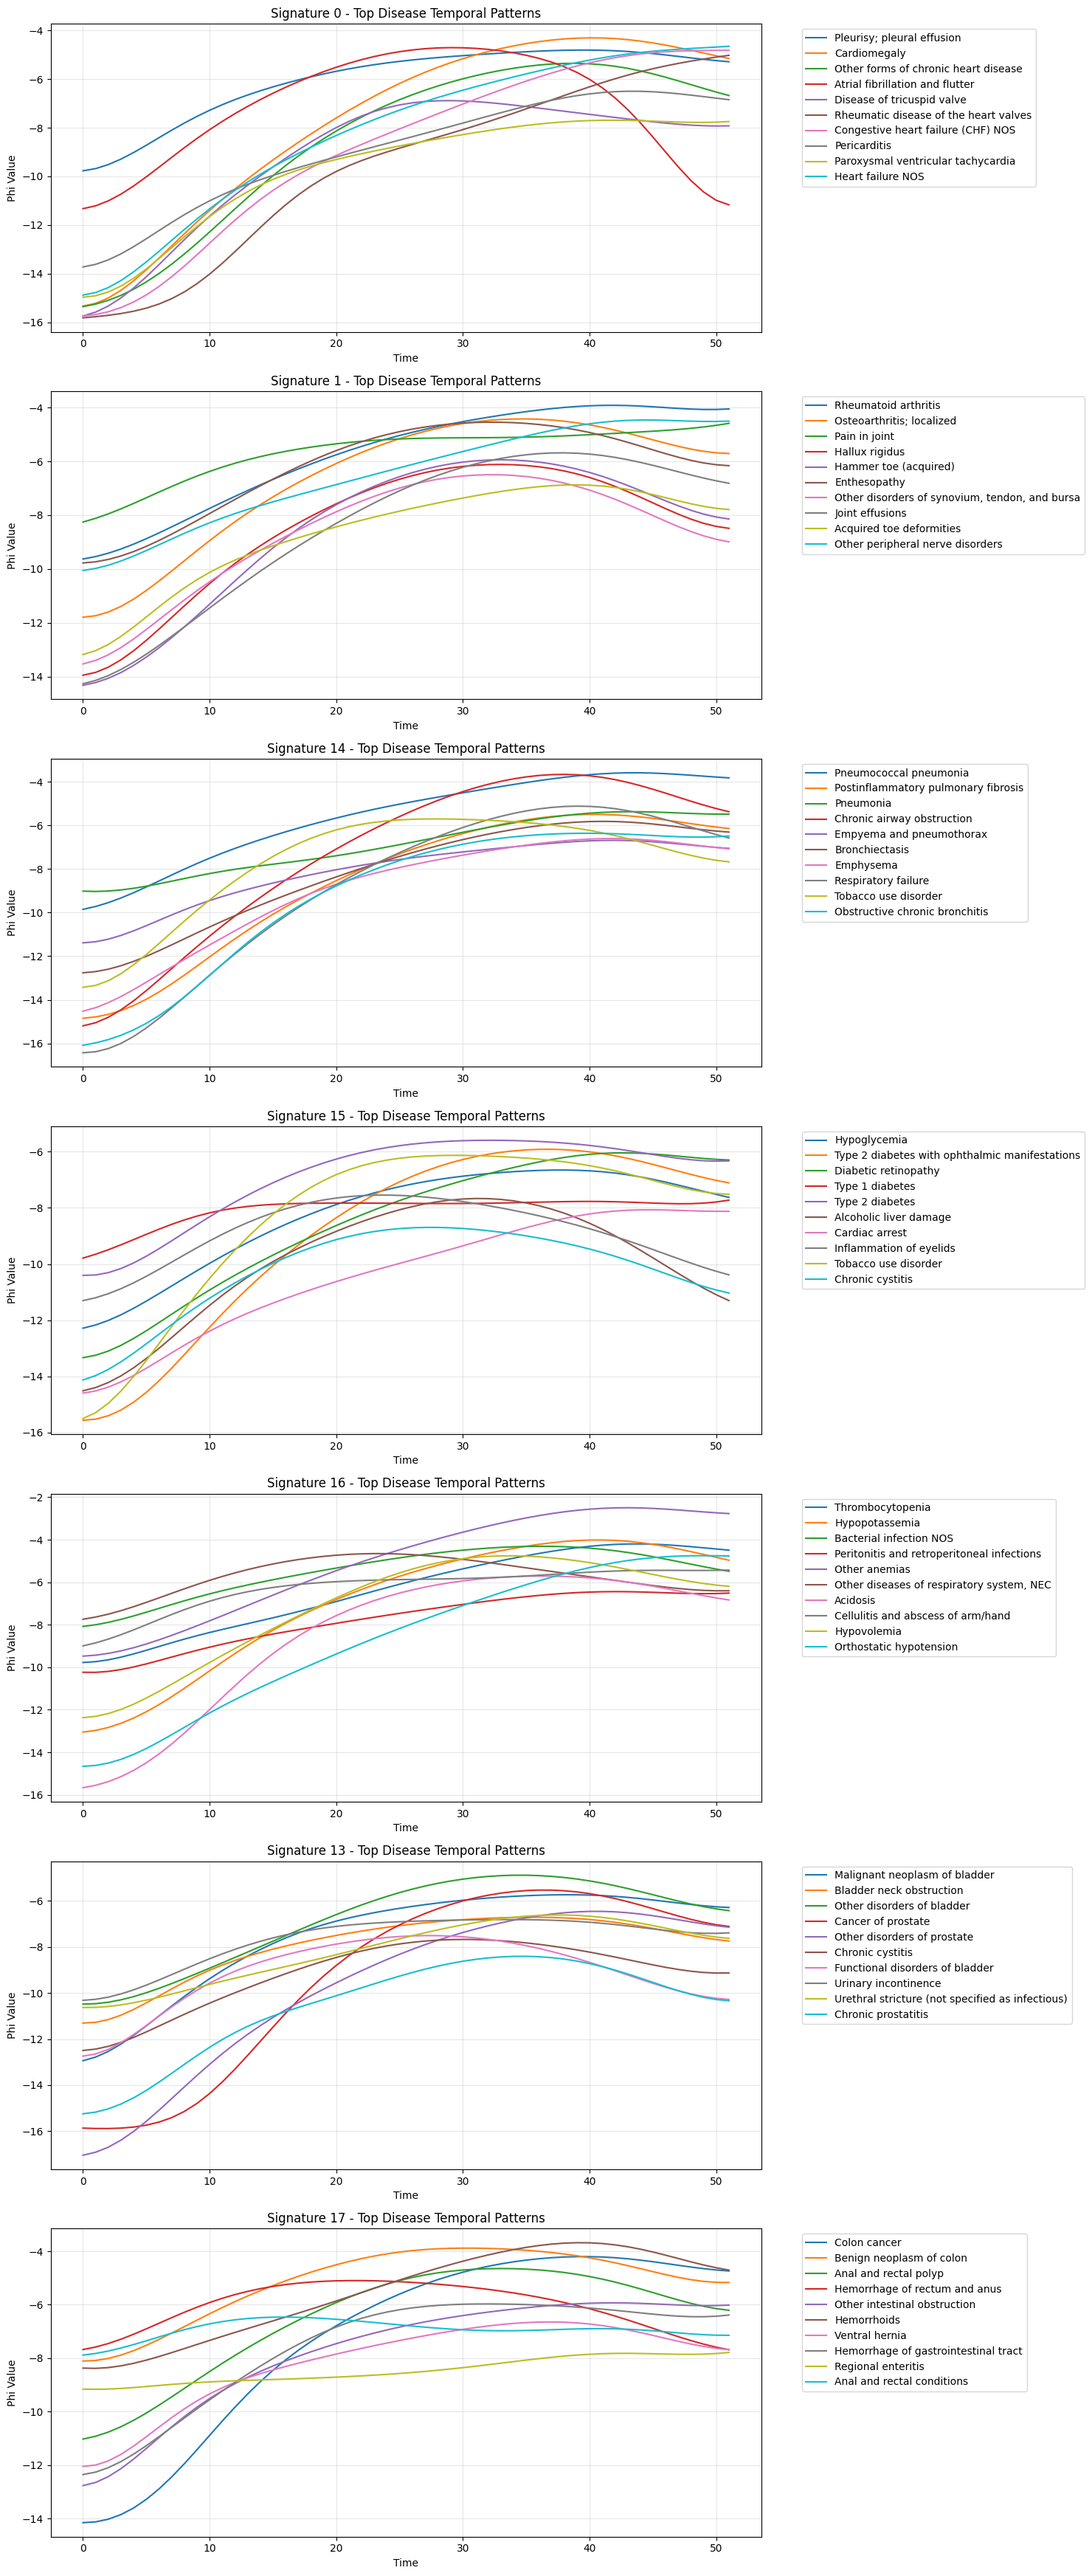

In [34]:
def plot_signature_temporal_patterns(model, disease_names, n_top=10, selected_signatures=None):
    """
    Show temporal patterns of top diseases for each signature
    """
    #phi = model.phi.detach().numpy()  # Shape: (K, D, T)
    #phi_avg = phi.mean(axis=2)  # Average over time

     # Get phi and prevalence
    phi = model.phi.detach().numpy()  # Shape: (K, D, T)
    prevalence_logit = model.logit_prev_t.detach().numpy()  # Shape: (D, T)
    
    # Center phi relative to prevalence
    phi_centered = np.zeros_like(phi)
    for k in range(phi.shape[0]):
        for d in range(phi.shape[1]):
            phi_centered[k, d, :] = phi[k, d, :] - prevalence_logit[d, :]
    
    # Average over time
    phi_avg = phi_centered.mean(axis=2)  # Shape: (K, D)
    
    # Select which signatures to plot
    if selected_signatures is None:
        selected_signatures = range(phi_avg.shape[0])
    
    # Create subplots for each selected signature
    n_sigs = len(selected_signatures)
    fig, axes = plt.subplots(n_sigs, 1, figsize=(15, 5*n_sigs))
    if n_sigs == 1:
        axes = [axes]
    
    for i, k in enumerate(selected_signatures):
        # Get top diseases
        scores = phi_avg[k, :]
        top_indices = np.argsort(scores)[-n_top:][::-1]
        
        # Plot temporal patterns
        ax = axes[i]
        for idx in top_indices:
            temporal_pattern = phi[k, idx, :]
            ax.plot(temporal_pattern, label=disease_names[idx])
        
        ax.set_title(f'Signature {k} - Top Disease Temporal Patterns')
        ax.set_xlabel('Time')
        ax.set_ylabel('Phi Value')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# First show the top diseases


# Then show their temporal patterns
# You can select specific signatures of interest:
disease_names=essentials['disease_names']
plot_signature_temporal_patterns(model, disease_names, selected_signatures=[0,1,14,15,16,13,17])

In [35]:
Y_avg_global = torch.mean(torch.tensor(Y) if isinstance(Y,np.ndarray) else Y, dim=2)
Y_avg_batch = torch.mean(torch.tensor(Y_100k) if isinstance(Y_100k, np.ndarray) else Y_100k, dim=2)


In [36]:
def compare_disease_patterns(k, true_psi, Y_avg_global, Y_avg_batch):
    """Compare disease patterns between global and batch data"""
    strong_diseases = (true_psi[k] > 0)
    
    # Get mean pattern for each dataset (average across patients)
    pattern_large = Y_avg_global[:, strong_diseases].mean(dim=0)  # Average across all patients
    pattern_small = Y_avg_batch[:, strong_diseases].mean(dim=0)  # Average across batch patients
    
    # Now both patterns are just length of strong_diseases
    correlation = torch.corrcoef(
        torch.stack([pattern_large, pattern_small])
    )[0,1]
    
    print(f"Signature {k} pattern correlation: {correlation:.3f}")
    print(f"Mean pattern difference: {(pattern_large - pattern_small).abs().mean():.3f}")

# Now use it
print("Comparing disease sharing patterns between global and batch data:")
for k in range(model.K):
    print(f"\nSignature {k}:")
    compare_disease_patterns(k, model.psi, Y_avg_global, Y_avg_batch)

Comparing disease sharing patterns between global and batch data:

Signature 0:
Signature 0 pattern correlation: 0.993
Mean pattern difference: 0.000

Signature 1:
Signature 1 pattern correlation: 0.999
Mean pattern difference: 0.000

Signature 2:
Signature 2 pattern correlation: 0.996
Mean pattern difference: 0.000

Signature 3:
Signature 3 pattern correlation: 0.987
Mean pattern difference: 0.000

Signature 4:
Signature 4 pattern correlation: 0.998
Mean pattern difference: 0.000

Signature 5:
Signature 5 pattern correlation: 0.999
Mean pattern difference: 0.000

Signature 6:
Signature 6 pattern correlation: 0.998
Mean pattern difference: 0.000

Signature 7:
Signature 7 pattern correlation: 0.999
Mean pattern difference: 0.000

Signature 8:
Signature 8 pattern correlation: 0.986
Mean pattern difference: 0.000

Signature 9:
Signature 9 pattern correlation: 0.993
Mean pattern difference: 0.000

Signature 10:
Signature 10 pattern correlation: 1.000
Mean pattern difference: 0.000

Signatu

In [37]:
initial_lambda

tensor([[[-0.0119, -0.0118, -0.0118,  ..., -0.0136, -0.0136, -0.0135],
         [-0.0159, -0.0159, -0.0159,  ..., -0.0168, -0.0168, -0.0168],
         [-0.0810, -0.0811, -0.0811,  ..., -0.0796, -0.0795, -0.0795],
         ...,
         [ 0.0387,  0.0386,  0.0386,  ...,  0.0380,  0.0380,  0.0380],
         [-0.0380, -0.0380, -0.0380,  ..., -0.0371, -0.0371, -0.0371],
         [ 0.0371,  0.0371,  0.0371,  ...,  0.0357,  0.0356,  0.0355]],

        [[ 0.0696,  0.0695,  0.0694,  ...,  0.0707,  0.0708,  0.0709],
         [ 0.0092,  0.0092,  0.0092,  ...,  0.0112,  0.0112,  0.0113],
         [-0.0494, -0.0495, -0.0495,  ..., -0.0485, -0.0486, -0.0488],
         ...,
         [-0.0488, -0.0489, -0.0489,  ..., -0.0511, -0.0511, -0.0511],
         [ 0.0407,  0.0407,  0.0407,  ...,  0.0403,  0.0401,  0.0400],
         [ 0.0328,  0.0328,  0.0328,  ...,  0.0323,  0.0323,  0.0324]],

        [[ 0.2714,  0.2714,  0.2714,  ...,  0.2713,  0.2714,  0.2715],
         [ 0.1573,  0.1573,  0.1573,  ...,  0

In [39]:
model.lambda_-initial_lambda

tensor([[[ 5.3989e-06,  1.5711e-06,  5.9232e-07,  ...,  2.5239e-06,
          -1.3029e-06, -6.1961e-06],
         [-4.6527e-05, -3.3736e-05, -2.0392e-05,  ..., -1.0580e-06,
           3.3528e-06,  4.2841e-06],
         [-1.6540e-06, -4.6194e-07,  8.9407e-08,  ...,  4.6194e-07,
          -2.3395e-06, -5.8860e-07],
         ...,
         [-4.6454e-06,  5.4017e-07,  2.9244e-06,  ..., -3.3181e-05,
          -6.4317e-05, -1.0359e-04],
         [-4.9248e-06, -4.9546e-07, -3.8370e-07,  ..., -2.0970e-05,
          -8.6315e-06,  7.6666e-06],
         [-5.1148e-05, -3.8270e-05, -2.5325e-05,  ..., -2.6487e-06,
          -2.1122e-06,  4.6194e-07]],

        [[-2.1830e-05, -4.8727e-06,  2.5630e-06,  ...,  2.1458e-06,
          -6.0946e-06, -1.3284e-05],
         [-1.4821e-05, -1.4067e-05, -1.1781e-05,  ...,  1.8394e-05,
           2.6939e-05,  3.4281e-05],
         [ 4.4852e-06,  1.6466e-06, -1.1213e-06,  ..., -1.4156e-07,
           9.8348e-07,  7.0632e-06],
         ...,
         [-4.4331e-06, -3